# Import right dependencies

In [ ]:
import numpy as np
import h5py
import cv2
import numpy
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.metrics import classification_report, confusion_matrix

# Import dataset

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print(train_X.shape)
print(train_y.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(60000,)


# One hot encode train and test labels

In [ ]:
train_y_one_hot= to_categorical(train_y)
train_y_one_hot = np.einsum('vz->zv', train_y_one_hot)
test_y_one_hot= to_categorical(test_y)
test_y_one_hot = np.einsum('vz->zv', test_y_one_hot)
print(train_X.shape)
print(train_y_one_hot.shape)

(60000, 28, 28)
(10, 60000)


# Flatten and reshape train and test inputs

In [ ]:
train_x_flatten = train_X.reshape(train_X.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_X.reshape(test_X.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (784, 60000)
test_x's shape: (784, 10000)


# Define neural network architecture

In [ ]:
#input dymension, hidden_layers
layers_dims = [784, 30, 20, 15, 10]

# Define activation functions

In [ ]:
def relu(z):
    A = np.maximum(0,z)
    cache = z
    return A, cache

In [10]:
def sigmoid(z):
    s = s = 1 / (1 + np.exp(-z))
    cache = z
    return s, cache

In [11]:
def softmax(z):
    cache = z
    z_norm = z - np.max(z)
    exp = np.exp(z_norm)
    exp = exp / np.sum(exp, axis=0, keepdims=True)
    return exp, cache

# Define forward propagation functions

In [12]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [13]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [14]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache

# Define model forward function

In [15]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)

    return AL, caches

# Define cost functions

In [16]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -np.mean(Y * np.log(AL))
    cost = np.squeeze(cost)
    return cost

# Define activation function derivatives with respect to loss

In [17]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [18]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

# Define backward propagation functions

In [19]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.multiply(1/m,np.dot(dZ, A_prev.transpose()))
    db = np.multiply(1/m,np.sum(dZ, axis = 1, keepdims = True))
    dA_prev = np.dot(W.transpose(),dZ)

    return dA_prev, dW, db

In [20]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "softmax":
        dA_prev, dW, db = linear_backward(dA, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

# Define model backward function

In [21]:
def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = (AL - Y)

    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "softmax")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp
        grads["db" + str(l+1)] = db_temp

    return grads

In [22]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

# Define model

In [23]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.9, num_iterations = 3000, print_cost=False):

    np.random.seed(1)
    costs = []                         # keep track of cost
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

# Train model

In [25]:
parameters, costs = L_layer_model(train_x, train_y_one_hot, layers_dims, learning_rate=0.9, num_iterations=1000, print_cost=True)

Cost after iteration 0: 0.23168352039847226
Cost after iteration 100: 0.06343847286484046
Cost after iteration 200: 0.03292092726422999
Cost after iteration 300: 0.023615411554959456
Cost after iteration 400: 0.021803517460436253
Cost after iteration 500: 0.1942570632751025
Cost after iteration 600: 0.1379910288017511
Cost after iteration 700: 0.0903097563170221
Cost after iteration 800: 0.07826535464409139
Cost after iteration 900: 0.08295802475619302
Cost after iteration 999: 0.06508177593656059


# Define function for predictions and their accuracy

In [26]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)
    return np.argmax(probas, axis=0)

In [27]:
def accuracy(y, y_hat):
    acc = np.sum(y==y_hat)/len(y)
    return acc

# Make predictions on training data, get accuracy

In [28]:
pred_train = predict(train_x, train_y, parameters)

In [29]:
accuracy(train_y, pred_train)

np.float64(0.79625)

# Print confusion matrix and classification report for train predictions

In [30]:
print(confusion_matrix(train_y, pred_train))
print(classification_report(train_y, pred_train))

[[5569    0   90   27   24   88   54   45    9   17]
 [   0 6479   62   50    5   12    3   28   75   28]
 [  42   23 5099  349  122   14   56  132   51   70]
 [  33    8 2765 2379    9  338   26  330  187   56]
 [   5   13   45    1 4434    1   83   23   14 1223]
 [ 276    8   59  272   60 3805  212  142  518   69]
 [  68    2  117    6  339   92 5256    0   36    2]
 [  14   13   83   15   36    0    1 5968    4  131]
 [  21   75   64  429   53  296   85  116 4444  268]
 [  29   15    6   19  135   33    6 1307   57 4342]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      5923
           1       0.98      0.96      0.97      6742
           2       0.61      0.86      0.71      5958
           3       0.67      0.39      0.49      6131
           4       0.85      0.76      0.80      5842
           5       0.81      0.70      0.75      5421
           6       0.91      0.89      0.90      5918
           7       0.74      0.95   

# Make predictions on test data, get accuracy

In [31]:
pred_test = predict(test_x, test_y, parameters)

# Print confusion matrix and classification report for test predictions

In [32]:
print(confusion_matrix(test_y, pred_test))
print(classification_report(test_y, pred_test))

[[ 937    0   13    3    1    8   10    5    1    2]
 [   0 1100    6   11    1    1    2    3    9    2]
 [   9    2  883   71   15    3    9   19   11   10]
 [   4    0  453  405    0   58    3   47   30   10]
 [   1    1    6    0  745    0    9    2    1  217]
 [  54    1   13   45    7  618   40   32   76    6]
 [  22    1   24    0   60   16  823    0   12    0]
 [   1    7   28    3    4    0    0  963    0   22]
 [   8    8    9   58   16   65   21   30  707   52]
 [  13    7    0    2   21    4    1  165    9  787]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       980
           1       0.98      0.97      0.97      1135
           2       0.62      0.86      0.72      1032
           3       0.68      0.40      0.50      1010
           4       0.86      0.76      0.80       982
           5       0.80      0.69      0.74       892
           6       0.90      0.86      0.88       958
           7       0.76      0.94   

# Plot part of the incorrectly predicted images and append them to list

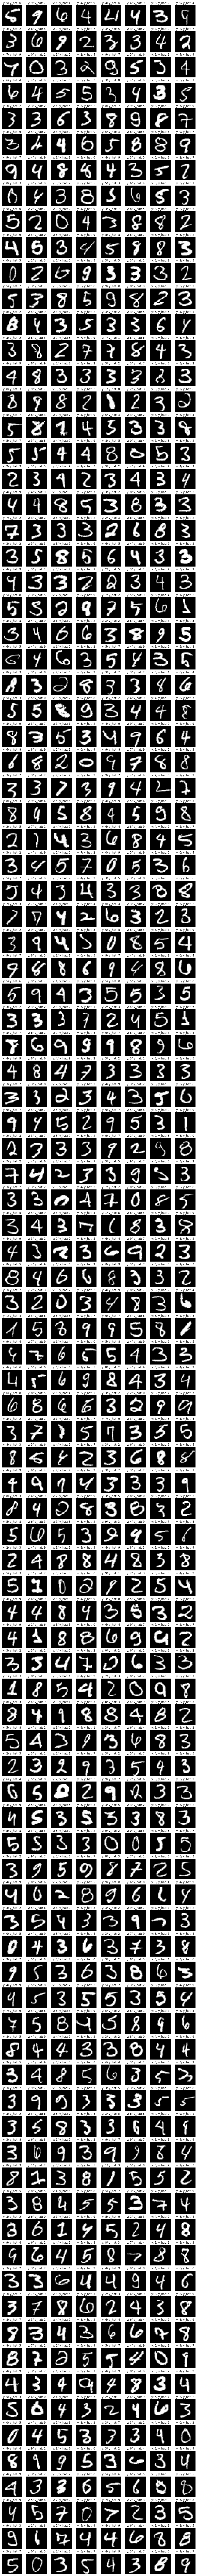

In [43]:
fig = plt.figure(figsize=(15,200))
z = 0
incorrect_list = []
for i in range(len(test_y)):
    y = test_y[i]
    y_hat = pred_test[i]
    if y != y_hat:
        if z >= 800:
            break
        z += 1
        incorrect_list.append(i)
        ax = fig.add_subplot(100, 8, z)
        ax.imshow(test_X[i], cmap=plt.get_cmap('gray'))

        ax.set_title('y: {y}/ y_hat: {y_hat}'
                     .format(y=test_y[i], y_hat=pred_test[i]))
        plt.axis('off')

While visualizing the incorrectly predicted samples I noticed that the number of subplots is limited to 100x8=800. So I stopped the loop when it reaches 800 to avoid errors.With This way I can see only the first 800 incorrect predictions without getting an error.

# Define function for getting derivative of loss with respect to input for saliency maps

In [44]:
def get_saliency_map(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2
    p = np.zeros((1,m))

    probas, caches = L_model_forward(X, parameters)
    cost = compute_cost(probas, y)
    grads = L_model_backward(probas, y, caches)
    dy_dx = grads["dA0"]

    return np.argmax(probas, axis=0), dy_dx

# Prepare incorrectly predicted data for saliency maps

In [45]:
saliency_test = test_x[:, incorrect_list]
saliency_test.reshape(saliency_test.shape[0],len(incorrect_list))
print(saliency_test.shape)

saliency_test_y = test_y[incorrect_list]
print(saliency_test_y.shape)

test_y_one_hot_for_saliency = to_categorical(saliency_test_y)
test_y_one_hot_for_saliency = np.einsum('vz->zv', test_y_one_hot_for_saliency)

(784, 800)
(800,)


# Get predictions and derivative of loss with respect to input

In [46]:
probas, dy_dx = get_saliency_map(saliency_test, test_y_one_hot_for_saliency, parameters)

# Reshape and normalize results for plot

In [47]:
dy_dx_one_rs = dy_dx.reshape(28,28,dy_dx.shape[1])

normalized_tensor = np.multiply(
    255, (((dy_dx_one_rs - np.min(dy_dx_one_rs))
    / (np.max(dy_dx_one_rs) - np.min(dy_dx_one_rs)))))

# Apply penalty for smaller values

In [48]:
log = (1/(1+np.log((np.max(normalized_tensor) - normalized_tensor + 0.0001))))
normalized_tensor_weighted = np.multiply(normalized_tensor,log)

# The brightest points show the highest impact on loss

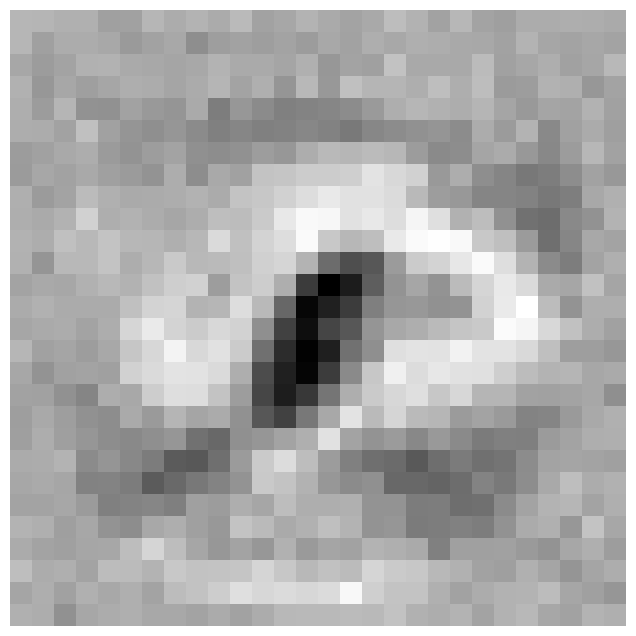

In [49]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(normalized_tensor_weighted[:,:,1], cmap='gray')
plt.show()

# Darken the prediction images so saliency points become the brightest ones in image

In [50]:
saliency_test = test_x[:, incorrect_list]
saliency_test.reshape(saliency_test.shape[0],len(incorrect_list))
saliency_test = saliency_test.reshape(28,28,saliency_test.shape[1])
saliency_test = np.multiply(
    20, (saliency_test - np.min(saliency_test))
    / (np.max(saliency_test) - np.min(saliency_test))
)

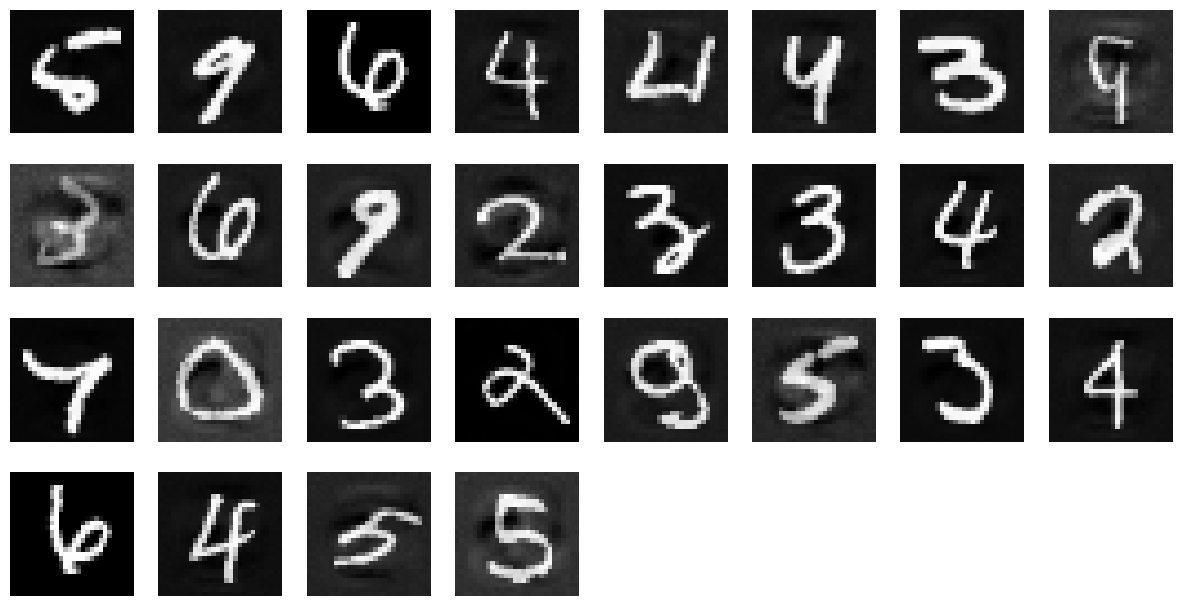

In [51]:
fig = plt.figure(figsize=(15,200))
z = 0
for i in range(saliency_test.shape[1]):
    z += 1
    picture_i = saliency_test[:,:,i]
    saliency_map_i = normalized_tensor_weighted[:,:,i]
    ax = fig.add_subplot(100, 8, z)
    super_imposed = cv2.addWeighted(picture_i, 0.5, saliency_map_i, 0.5, 0.0, dtype=cv2.CV_64F)
    ax.imshow(super_imposed, cmap=plt.get_cmap('gray'))

    plt.axis('off')